<a href="https://colab.research.google.com/github/BrendanBena/sqft-ml/blob/main/SQFT_Book.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-----
-----


# **SQFT Colab Book**

#### Colab Notebook for 2020 Square Footage Research n Dev. Project
---------

> *Note: In the event of major errors to the notebook:* Click **Runtime -> Factory Reset Runtime**

---------
---------
\
**Structure of this Notebook:**

### 1.   Import and Initial Setup Code
  - Contains notebook-wide imports for SQFT Book as well as functionality for storing data locally (rather than pulling from cloud).

> ---

### 2.   Estimation (*HorizonNet*)

Allows for 1-D inference of room layout on a pano image using HorizonNet

  * **Preprocessing**
    - Preprocesses the given image(s) to normalize and tilt in camera
  * **Inference**
    - Performs HorizonNet inference and estimates corners and vertices
  * **Corner Grabbing** 
    - Steps in the middle of the HorizonNet process to grab the corners of a room and saves them to a pickle
  * **Estimation** 
    - Uses corners of a room from a pickle file to estimate a polygon and calculate area

> ---

### 3.   Classification
* **Classifier Model**
  - Contains code to pull in dataset, then train a CNN classifier of the given dataset. Functionality is availability to remove data based on certain heuristics and serialize and save the trained model. Written with DULib wrapper to PyTorch
* **Classifier Handler**
  - Script to take an image, load a trained model, and predict the type of image.
* **Multiple-Runs Block**
  - Block that allows for multiple models to be run with a multitude of different archs, etc.
* **Some Data Analysis**
  - Example functions to check out data from our given data set.






    
  


## 1. Import and Initial Setup Code


In [ ]:
# Remember to assure a GPU is enabled           
#  Ribbon -> Runtime -> Change runtime type
# DUlib will not import if GPU is not enabled

# Import PyTorch, DUlib, Pycuda and mount google drive
# -- Below loads the data locally 
from google.colab import drive
from pathlib import Path
import sys
import pickle

drive.mount('/content/drive', force_remount=True)
zip_path = '/content/drive/MyDrive/Shanghai/.data/Structured3D_panos_full_rgb_rawlight_25.zip'
!cp {zip_path} .
!unzip -q Structured3D_panos_full_rgb_rawlight_25.zip
!rm Structured3D_panos_full_rgb_rawlight_25.zip
!pip install area 
!pip install open3d
!pip install pylsd

# View GPU, VRAM, CUDA, etc...
!nvidia-smi

# Uninstalls OpenCV and reinstalls older version
#   For preprocessing step
!pip uninstall opencv-python -y
!pip install opencv-python==3.4.2.17

Mounted at /content/drive
  Created wheel for area: filename=area-1.1.1-cp37-none-any.whl size=3609 sha256=e63022e0e0b9a85438cd0d85b1aabb7178c84b02ad5960c0aa1598cd1d13129b
  Stored in directory: /root/.cache/pip/wheels/66/c0/12/b2ef12e07a617ba6f7aaeb32348ea6f14205cc1985f51a134e
Successfully built area
     |████████████████████████████████| 188.4MB 71kB/s 
     |████████████████████████████████| 51kB 4.7MB/s 
  Created wheel for pylsd: filename=pylsd-0.0.2-cp37-none-any.whl size=46365 sha256=93242725b188a6e1aee4520a6bff9269fd3c94d7e5240ab4298b4eb6902166d2
  Stored in directory: /root/.cache/pip/wheels/10/8c/58/685c8468be8e9b1a44d41f7baa0e9ead5de6b6cf91a67fad1d
Successfully built pylsd
/bin/bash: nvidia-: command not found
Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 25.0MB 119kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


## 2. Estimation (*HorizonNet*)

> #### **a. Preprocessing**

In [ ]:
# Run the preprocessing script on one or any number of images
#   --rgbonly tag gives only the preprocessed image
!python /content/drive/MyDrive/Shanghai/sqft-2020-21/ml/sqftNet/preprocess.py --img_glob /content/drive/MyDrive/Shanghai/sqft-2020-21/ml/sqftNet/assets/images/bedroom2.JPG --output_dir /content/drive/MyDrive/Shanghai/sqft-2020-21/ml/sqftNet/assets/preprocessed/ --rgbonly

Processing /content/drive/MyDrive/Shanghai/sqft-2020-21/ml/sqftNet/assets/images/bedroom2.JPG


> #### **b. Inferencing**

In [ ]:
# Run the inference script. Works with single or multiple images in the form: "/dir/images/*"
#   - Will break if the --rgbonly tagged is not used prior
#     * Can be fixed if images are deleted or the images endings are specificied
!python /content/drive/MyDrive/Shanghai/sqft-2020-21/ml/sqftNet/inference.py --pth /content/drive/MyDrive/Shanghai/sqft-2020-21/ml/sqftNet/ckpt/resnet50_rnn__st3d.pth --img_glob "/content/drive/MyDrive/Shanghai/sqft-2020-21/ml/sqftNet/assets/preprocessed/*" --output_dir /content/drive/MyDrive/Shanghai/sqft-2020-21/ml/sqftNet/assets/layouts  --visualize

Inferencing: 100% 1/1 [00:00<00:00,  1.74it/s]


> #### **c. Layout Grabbing**

In [ ]:
# Run the layout viewer, which just extracts the corners and places them in the given output_dir
!python /content/drive/MyDrive/Shanghai/sqft-2020-21/ml/sqftNet/layout_viewer_sqft.py --img_glob "/content/drive/MyDrive/Shanghai/sqft-2020-21/ml/sqftNet/assets/preprocessed/*" --layout_dir /content/drive/MyDrive/Shanghai/sqft-2020-21/ml/sqftNet/assets/layouts/ --output_dir /content/drive/MyDrive/Shanghai/sqft-2020-21/ml/sqftNet/assets/corners

Grabbing corners for /content/drive/MyDrive/Shanghai/sqft-2020-21/ml/sqftNet/assets/preprocessed/bedroom2.png
Saved pickle for bedroom2 



> #### **d. Corner Estimating**

Area of the room (m):  8.264192716454808
Area of the room (ft):  88.95577039991954


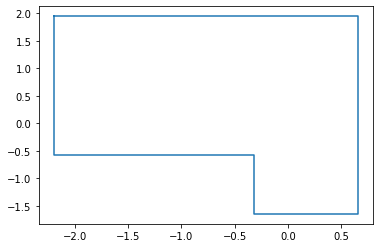

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from shapely.geometry import Polygon
import argparse, csv

pickle_path = "/content/drive/MyDrive/Shanghai/sqft-2020-21/ml/sqftNet/assets/corners/bedroom2.pkl"
with open(pickle_path, "rb") as f:
    plane_corners = pickle.load(f)

tuple_corners = tuple(tuple(corner) for corner in plane_corners)

polygon = Polygon(tuple_corners)
print("Area of the room (m): ", polygon.area) 
print("Area of the room (ft): ", polygon.area*10.764) 

# Plot the data 
x,y = polygon.exterior.xy
plt.plot(x,y)
plt.show()

## 3. Classification

> ### a. Classifier Model Training



In [ ]:
# classifier_trainer.py    Authors: B. Bena, R. McKinney, S. Simmons 
# Pulled largely from Simmons' DataLoader tutorial
#	on the DL@DU Page. Code is adapted to fit the
#	2020 SQFT AI Team's first task of room classification

# Imports for Dataloading and Model Training
from skimage import io
import time, random
import argparse, csv
import pickle
import pandas as pd
import du.lib as du
import du.conv.models
import pathlib, torch
import torch.nn as nn
import torchvision.transforms as t
from torch.utils.data import Dataset, DataLoader


# set up command-line switches
parser = du.utils.standard_args('Convolutional model.', epochs=20, lr=0.003,
	mo=0.99, bs=20, props=(0.7,0.15,0.15), channels=(1,24,32,64,128,256), 
  widths = (896,448,224,112,56), gpu=(-1,-1),
	graph=0, verb=3, cm=False, print_lines=(-1,))
p = parser.add_argument
p("-ser","--serialize",help="save the trained model",action="store_true", default = True)
p("-load","--load",help="load a trained model",action="store_true", default = False)
p("-pkl","--pickle",help="pickle a classifying dict",action="store_true", default = True)
args, unknown = parser.parse_known_args() # For use in Colab


# Where the Files are stored
image_dir = '/content/Structured3D_panos_full_rgb_rawlight_25/'
csv_file = 'ground_truth.csv'


print("\nOpening CSV...")


# Grab labels from csv
with open(image_dir + csv_file) as csvfile:
	csvfile = list(csv.reader(csvfile))
	labels = set()
	for i in range(len(csvfile)):
		labels.add(csvfile[i][0])
	labels = list(labels)
	label2int = {}
	for i, label in enumerate(labels):
		label2int[label] = i


# subclass Dataset appropriately for the training data
class ImageData(Dataset):
	def __init__(self, dataframe, *transforms):
		self.frame = dataframe
		self.dir = image_dir
		self.transforms = transforms

	def __len__(self):
		return len(self.frame)

	def __getitem__(self, idx):
		imagefile = self.dir + self.frame.iloc[idx, 1] + '.png'
		imagelabel = label2int[self.frame.iloc[idx, 0]]
		return tuple(tform(xs) for tform, xs in zip(
			self.transforms,
			(io.imread(imagefile), imagelabel)
			) if tform is not None)


# In case we are running this on the jobs queue, use a logstring
logstring = ''

# print some of the learning hyper-parameters, etc.
logstring += du.utils.args2string(
    args, ['epochs','bs','lr','mo','gpu'],
    timestamp = True if args.verb < 3 else False) + '\n'


# Transform the image first to Grayscale, then to a Tensor,
#   and finally, squeeze the extra dim
image_transform = t.Compose([
	t.ToPILImage(),
	t.Resize((64,128)),
	t.Grayscale(),
	t.ToTensor(),
	t.RandomHorizontalFlip(p=0.75),
	t.Lambda(lambda xs: xs.squeeze(0))])

# get the all of the image data in the form of a pandas dataframe
df = pd.read_csv(image_dir+csv_file, names=["Room Type", "ID", "SQFT"])













# Dropping some unneccesary data
df.drop(df.loc[df['Room Type']=='undefined'].index, inplace=True)
df.drop(df.loc[df['Room Type']=='balcony'].index, inplace=True)
df.drop(df.loc[df['Room Type']=='study'].index, inplace=True)
df.drop(df.loc[df['Room Type']=='garden'].index, inplace=True)
df.drop(df.loc[df['Room Type']=='store room'].index, inplace=True)
df.drop(df.loc[df['Room Type']=='corridor'].index, inplace=True)
df.drop(df.loc[df['Room Type']=='studio'].index, inplace=True)
df.drop(df.loc[df['Room Type']=='dining room'].index, inplace=True)

#Testing dropping large room sizes
index_names = df[ df['SQFT'] > 300 ].index 
df.drop(index_names, inplace = True)

#del label2int['store room']
#del label2int['dining room']
#del label2int['undefined']
#del label2int['balcony']
#del label2int['study']
#del label2int['garden']
#del label2int['corridor']
#del label2int['studio']

#del int2label['store room']
#del int2label['dining room']
#del int2label['undefined']
#del int2label['balcony']
#del int2label['study']
#del int2label['garden']
#del int2label['corridor']
#del int2label['studio']

#new_dict = {}
#x = 1
#for i, j in label2int.items():   
#  new_dict[i] = x
#  x += 1

#label2int = new_dict

# Classification dictionary
int2label = {v: k for k, v in label2int.items()}

print(label2int)
print(int2label)










# split out training, validation, and testing dataframes
if len(args.props) == 1:
    train_df = du.lib.split_df(df, args.props)
    logstring += f'Training {len(train_df)} examples'
else:
    train_df, valid_df, test_df = du.lib.split_df(df, args.props)
    logstring += 'Training/validating/testing on {}/{}/{} examples'.format(
        len(train_df), len(valid_df), len(test_df))


print("\nCreating DataLoader...")


# Create dataset and DataLoader
train_data = ImageData(train_df, image_transform)
train_loader = DataLoader(dataset=train_data, batch_size=args.bs)


print("\nComputing Means & St. Devs...")


# (online) compute the means and stdevs
(feats_means, feats_stdevs), = du.lib.online_means_stdevs(train_loader) 


# Create transforms for the images
feat_transform = t.Compose([
	    image_transform,
			t.Lambda(
      lambda xs: du.lib.standardize(xs,means=feats_means,stdevs=feats_stdevs))])
targ_transform = t.Lambda(lambda xs: torch.tensor(xs))


# re-instance TrainData using targs_transform so we output (feature, target) pairs
train_data = ImageData(train_df, feat_transform, targ_transform)
train_loader = DataLoader(dataset=train_data, batch_size=args.bs, num_workers=4, shuffle=True, pin_memory=True)


print("\nExtracting test features and targets...")


# create loaders for validation and testing
if len(args.props) > 1:
    valid_loader = DataLoader(
        ImageData(valid_df, feat_transform, targ_transform),
        batch_size=20, num_workers=2, pin_memory=True)
    test_loader = DataLoader(
        ImageData(test_df, feat_transform, targ_transform),
        batch_size=20, num_workers=2, pin_memory=True)


print("\nCreating model...")


# create a convolutional model
model =  du.conv.models.ConvFFNet(
	in_size = (64, 128),
	n_out = len(labels),
	channels = args.channels,
	widths = args.widths,
	means = feats_means,
  stdevs = feats_stdevs)
model.register_buffer('means', model.means)
model.register_buffer('stdevs', model.stdevs)


# Log the model 
if args.verb > 3:
    print(logstring)
    print(model)
elif args.verb == 3:
    print(logstring)
    print(model.repr_)
else:
    logstring += '\n' + model.repr_ + '\n' +'\n'

print()

# train the model
model = du.lib.train(
	model = model,
	crit = nn.NLLLoss(),
  verb=args.verb,
	bs = args.bs,
	epochs = args.epochs,
	train_data = train_loader,
  learn_params = {'lr':args.lr, "mo":args.mo},
	valid_data = valid_loader if len(args.props) < 1 else None)


# evaluate on train data
str_ = '\n' + 'Accuracy: training data '
str_ += f'{100*du.lib.class_accuracy(model, train_loader, class2name = int2label, show_cm=args.cm):.2f}% correct; '

# evaluate on test data
if len(args.props) > 1:   
		str_ += '\n' + 'Accuracy: test data '
		str_ += f'{100*du.lib.class_accuracy(model, test_loader, class2name = int2label, show_cm=args.cm):.2f}%. correct;'

# Log the calculation time
print(str_ if args.verb > 2 else logstring+str_+'\n'+time.ctime()+'\n')

# Adding serialization functionality
#serialize = True
if args.serialize:
  print('\nSaving model ... ', end='')
  torch.save(model.state_dict(), "/content/drive/MyDrive/Shanghai/ml/model_store/classifier.pth")
  print('Done.')


# Sace pickle of the dictionary
if args.pickle:
	with open('classifier_dict.pkl', 'wb') as handle:
		pickle.dump(int2label, handle, protocol=pickle.HIGHEST_PROTOCOL)


Opening CSV...
{'study': 0, 'laundry room': 1, 'kitchen': 2, 'dining room': 3, 'store room': 4, 'living room': 5, 'office': 6, 'bedroom': 7, 'balcony': 8, 'undefined': 9, 'corridor': 10, 'garden': 11, 'bathroom': 12, 'studio': 13}
{0: 'study', 1: 'laundry room', 2: 'kitchen', 3: 'dining room', 4: 'store room', 5: 'living room', 6: 'office', 7: 'bedroom', 8: 'balcony', 9: 'undefined', 10: 'corridor', 11: 'garden', 12: 'bathroom', 13: 'studio'}

Creating DataLoader...

Computing Means & St. Devs...

Extracting test features and targets...

Creating model...
epochs:20 bs:20 lr:0.003 mo:0.99 gpu:(-1,-1)
Training/validating/testing on 8442/1809/1809 examples
Conv.: ~channels~ `1` `24` `32` `64` `128` `256` `ReLU` ~batchnorm~:`before` ~dropout~:`0`
Dense: ~widths~ `2048` `896` `448` `224` `112` `56` `14` `ReLU` ~dropout~:`0`

training on cuda:0 (data is on cpu:0)
epoch 1/20; loss 1.27112
epoch 2/20; loss 0.853128
epoch 3/20; loss 0.697735
epoch 4/20; loss 0.615745
epoch 5/20; loss 0.51455
e

> ### b. Classifier Handler

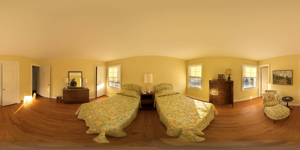


Your image is a: corridor


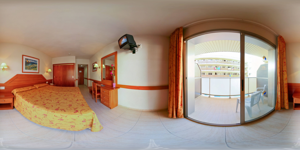


Your image is a: corridor


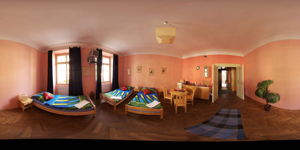


Your image is a: corridor


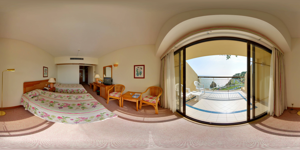


Your image is a: corridor


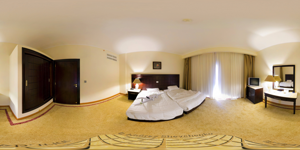


Your image is a: corridor


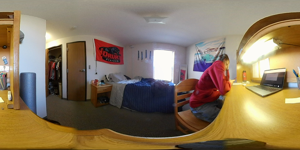


Your image is a: corridor


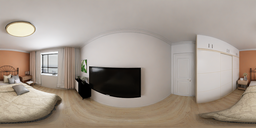


Your image is a: corridor


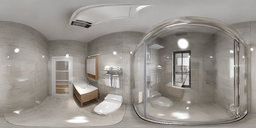


Your image is a: kitchen


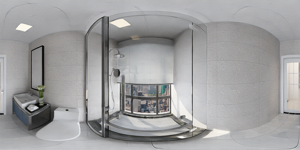


Your image is a: kitchen


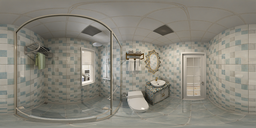


Your image is a: corridor


In [ ]:
# Imports 
import os
import torch
import pickle
import argparse
import matplotlib.pyplot as plt
import torchvision.transforms as t
from IPython.display import display
from PIL import Image as PImage
from skimage import io
from os import listdir
import du.lib as du
import du.conv.models


# Images
def load_images(path):
    img_folder = listdir(path)
    loaded_imgs = []
    for img in img_folder:
        if img.endswith(".png") or img.endswith(".JPG"): 
          loaded_img = PImage.open(path + img)
          #img.show()
          loaded_imgs.append(loaded_img)
          loaded_img.thumbnail((300,600))
    return loaded_imgs

# Function to predict the image
def predict_image(img, transforms, device, model):
    tensor_transform = t.ToTensor()
    img_tensor = tensor_transform(img)
    transformed_img = transforms(img_tensor).float()
    transformed_img = transformed_img.unsqueeze_(0)
    input = transformed_img.to(device)
    output = torch.exp(model(input))
    index = output.data.numpy()
    return index

# Paths
picklepath = '/content/drive/MyDrive/Shanghai/ml/model_store/classifier_dict.pkl'
modelpath = '/content/drive/MyDrive/Shanghai/ml/model_store/classifier.pth'
imagepath = "/content/drive/MyDrive/Shanghai/ml/images/"

# Load dictionary
loaded_dict = open(picklepath, 'rb')
int2label = pickle.load(loaded_dict)

# Instantiate an instance of proper model
device = torch.device("cpu")
model =  du.conv.models.ConvFFNet(
	in_size = (64, 128),
  n_out = len(int2label),
  channels=(1,24,32,64,128,256), 
  widths = (896,448,224,112,56))

# Load model and set to eval mode
model.load_state_dict(torch.load(modelpath), strict = False)
model.eval()#.to(device)

# Image transforms necessary to run through the model
image_transforms = t.Compose([
	t.ToPILImage(),
	t.Resize((64,128)),
	t.Grayscale(),
	t.ToTensor(),
	t.Lambda(lambda xs: xs.squeeze(0)),
	t.Lambda(
      lambda xs: du.lib.standardize(xs,means=model.means,stdevs=model.stdevs))])

if os.path.isdir(imagepath):
    images = load_images(imagepath)
    for image in images:
      prediction = predict_image(image, image_transforms, device, model)
      display(image) 
      print("\nYour image is a:", int2label[prediction.argmax()])
else:
    image = PImage.open(imagepath)
    prediction = predict_image(image, image_transforms, device, model)
    display(image) 
    print("\nYour image is a:", int2label[prediction.argmax()])

> ### c. Multiple Runs Testing Block

In [ ]:
#This is set up for quick an easy running of multiple models 
# of different flavors.
# BE SURE to run the first code block before running this block
file_path = '/content/drive/MyDrive/Shanghai/ml/model_files/classifier_trainer.py'
!cp {file_path} .

!python classifier_trainer.py -e 1
!python classifier_trainer.py -e 2

cp: cannot stat '/content/drive/MyDrive/Shanghai/ml/model_files/classifier_trainer.py': No such file or directory
python3: can't open file 'classifier_trainer.py': [Errno 2] No such file or directory
python3: can't open file 'classifier_trainer.py': [Errno 2] No such file or directory


In [ ]:
!python /content/drive/MyDrive/Shanghai/ml/model_files/classifier_handler.py -ip /content/drive/MyDrive/Shanghai/ml/images/ -mp /content/classifier.pth -pp /content/classifier_dict.pkl

python3: can't open file '/content/drive/MyDrive/Shanghai/ml/model_files/classifier_handler.py': [Errno 2] No such file or directory


> ### d. Some Data Analysis 




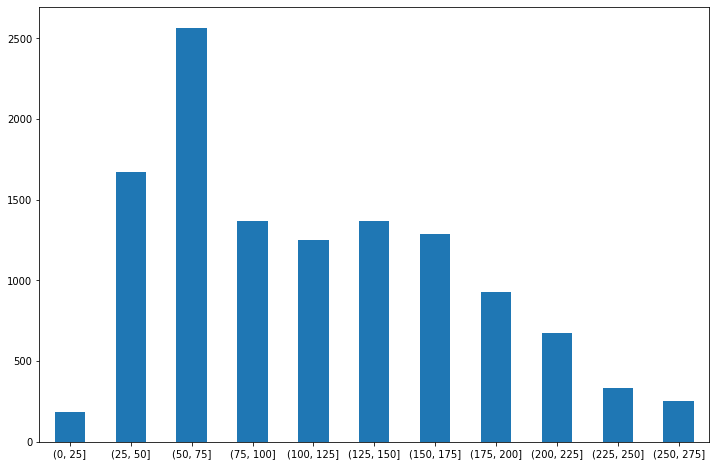

(12058, 3)


In [ ]:
# Imports for Dataloading and Model Training
from skimage import io
import pandas as pd
import pathlib, torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as t
import torch.nn as nn
import csv
%matplotlib inline
from matplotlib import pyplot as plt
import random

props=(1.0)

image_dir = '/content/Structured3D_panos_full_rgb_rawlight_25/'
csv_file = 'ground_truth.csv'

# Defining a function to rotate images 
def tensorCat(tensor):
  rotations = [0,.25,.50,.75]
  rot_factor = random.choice(rotations)
  index = int(len(tensor) * rot_factor)
  tensor_front = tensor[:,:index]
  tensor_back = tensor[:,index:]
  new_tensor = torch.cat([tensor_back,tensor_front], dim=1)
  return new_tensor

# subclass Dataset appropriately for the training data
class ImageData(Dataset):
	def __init__(self, dataframe, *transforms):
		self.frame = dataframe
		self.dir = image_dir
		self.transforms = transforms

	def __len__(self):
		return len(self.frame)

	def __getitem__(self, idx):
		imagefile = self.dir + self.frame.iloc[idx, 1] + '.png'
		imagelabel = label2int[self.frame.iloc[idx, 0]]
		return tuple(tform(xs) for tform, xs in zip(
			self.transforms,
			(io.imread(imagefile), imagelabel)
			) if tform is not None)
  
# get the all of the image data in the form of a pandas dataframe
df = pd.read_csv(image_dir+csv_file, names=["Room Type", "ID", "SQFT"])

# Dropping some unneccesary data
df.drop(df.loc[df['Room Type']=='undefined'].index, inplace=True)
df.drop(df.loc[df['Room Type']=='balcony'].index, inplace=True)
df.drop(df.loc[df['Room Type']=='study'].index, inplace=True)
df.drop(df.loc[df['Room Type']=='garden'].index, inplace=True)
df.drop(df.loc[df['Room Type']=='store room'].index, inplace=True)
df.drop(df.loc[df['Room Type']=='corridor'].index, inplace=True)
df.drop(df.loc[df['Room Type']=='studio'].index, inplace=True)
df.drop(df.loc[df['Room Type']=='office'].index, inplace=True)
df.drop(df.loc[df['Room Type']=='dining room'].index, inplace=True)
df.drop(df.loc[df['Room Type']=='laundry room'].index, inplace=True)
#df.drop(df.loc[df['Room Type']=='living room'].index, inplace=True)

test_image = image_dir + df.iloc[10, 1] + '.png'

#array = io.imread(test_image)[0] 
#plt.imshow(io.imread(test_image))#, interpolation='nearest')
#plt.show()
#image_tensor = torch.from_numpy(io.imread(test_image))
#new_image = tensorCat(image_tensor)
#new_image = new_image.numpy()
#plt.imshow(new_image)
#plt.show()

#df['Room Type'].value_counts().plot(kind='bar',figsize=(9, 9))

#print("Max Sq. Footage: ", max(df['SQFT']))

#print(df.sort_values(by='SQFT', ascending=False))

out = pd.cut(df['SQFT'], bins=[0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275])
ax = out.value_counts(sort=False).plot.bar(rot=0, figsize=(12,8))
plt.show()


index_names = df[ df['SQFT'] > 300 ].index 
df.drop(index_names, inplace = True)
print(df.shape)

#### **Corner Estimation Testing**

In [ ]:
# Estimator script takes a given image + pickle and creates a polygon then computes the area
!python /content/drive/MyDrive/Shanghai/HorizonNet/estimator_sqft_test.py --pickle_path /content/drive/MyDrive/Shanghai/ml/corners/bedroom1.pkl